In [1]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 

# Deep learning
import tensorflow as tf 

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import losses

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# Downloading data 
!python3 dataDownload.py

# Creating tidy data
!python3 createTidyData.py

Read municipality data in 0.33 seconds
Rows read: 13912
Read patient data in 0.65 seconds
Rows read: 35911
Data saved in data/2020-11-16


In [4]:
# Reading the data 
d = pd.read_csv('data/tidy_data.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only a subset of features
dLSTM = d.drop('day', axis=1)

In [5]:
dLSTM = series_to_supervised(dLSTM, n_in=3)

# Getting the t1 names 
t1 = [x for x in dLSTM.columns if '(t)' in x]

# Leaving only var 1
t1 = list(set(t1) - set(['var1(t)']))

# Droping the current info 
dLSTM = dLSTM.drop(t1, axis=1)

# Reseting the index 
dLSTM.reset_index(inplace=True, drop=True)

In [6]:
# Defining how many last day data to use in validation 
n_last = 3

# Spliting to training and validation sets 
test = dLSTM.tail(n_last)
train = dLSTM[~dLSTM.index.isin(test.index)]

# split into input and outputs
train_X, train_y = train.drop('var1(t)', axis=1), train['var1(t)']
test_X, test_y = test.drop('var1(t)', axis=1), test['var1(t)']

# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(245, 306) (245,) (3, 306) (3,)


In [7]:
# Input shape
inputRegression = Input(shape=(train_X.shape[1], ))

# Adding one output linear neuron
neuron = Dense(1, activation='linear')(inputRegression)

# Defining the model
model = Model(inputRegression, neuron)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 306)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 307       
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Initiating the optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# Compiling the model
model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

# Fitting the model
history = model.fit(train_X, train_y, epochs = 1000, batch_size=16, validation_data=(test_X, test_y))

Epoch 1/1000
16/16 [==============================] - 0s 6ms/step - loss: 255.8521 - val_loss: 479.1767
Epoch 2/1000
16/16 [==============================] - 0s 1ms/step - loss: 245.5866 - val_loss: 525.5630
Epoch 3/1000
16/16 [==============================] - 0s 1ms/step - loss: 235.9192 - val_loss: 567.8831
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 226.3331 - val_loss: 607.9568
Epoch 5/1000
16/16 [==============================] - 0s 1ms/step - loss: 217.5976 - val_loss: 652.0738
Epoch 6/1000
16/16 [==============================] - 0s 1ms/step - loss: 208.9959 - val_loss: 691.7997
Epoch 7/1000
16/16 [==============================] - 0s 1ms/step - loss: 201.9825 - val_loss: 731.2458
Epoch 8/1000
16/16 [==============================] - 0s 1ms/step - loss: 195.8035 - val_loss: 757.4202
Epoch 9/1000
16/16 [==============================] - 0s 1ms/step - loss: 190.9317 - val_loss: 784.9092
Epoch 10/1000
16/16 [==============================] - 0s 1ms/st

16/16 [==============================] - 0s 1ms/step - loss: 89.7659 - val_loss: 382.9238
Epoch 80/1000
16/16 [==============================] - 0s 2ms/step - loss: 88.9291 - val_loss: 372.6418
Epoch 81/1000
16/16 [==============================] - 0s 2ms/step - loss: 88.0202 - val_loss: 365.6439
Epoch 82/1000
16/16 [==============================] - 0s 2ms/step - loss: 87.2772 - val_loss: 365.7392
Epoch 83/1000
16/16 [==============================] - 0s 1ms/step - loss: 86.2265 - val_loss: 360.5706
Epoch 84/1000
16/16 [==============================] - 0s 2ms/step - loss: 85.3554 - val_loss: 345.6881
Epoch 85/1000
16/16 [==============================] - 0s 1ms/step - loss: 84.5358 - val_loss: 335.1375
Epoch 86/1000
16/16 [==============================] - 0s 1ms/step - loss: 83.6311 - val_loss: 328.2284
Epoch 87/1000
16/16 [==============================] - 0s 1ms/step - loss: 82.7913 - val_loss: 321.6120
Epoch 88/1000
16/16 [==============================] - 0s 2ms/step - loss: 81.

16/16 [==============================] - 0s 2ms/step - loss: 44.7889 - val_loss: 208.3840
Epoch 158/1000
16/16 [==============================] - 0s 1ms/step - loss: 44.4205 - val_loss: 207.4366
Epoch 159/1000
16/16 [==============================] - 0s 1ms/step - loss: 44.1253 - val_loss: 209.8715
Epoch 160/1000
16/16 [==============================] - 0s 1ms/step - loss: 43.7516 - val_loss: 212.8532
Epoch 161/1000
16/16 [==============================] - 0s 1ms/step - loss: 43.3806 - val_loss: 212.3442
Epoch 162/1000
16/16 [==============================] - 0s 1ms/step - loss: 43.1262 - val_loss: 213.9923
Epoch 163/1000
16/16 [==============================] - 0s 1ms/step - loss: 42.7942 - val_loss: 217.2714
Epoch 164/1000
16/16 [==============================] - 0s 1ms/step - loss: 42.7233 - val_loss: 216.6320
Epoch 165/1000
16/16 [==============================] - 0s 1ms/step - loss: 42.1158 - val_loss: 227.8504
Epoch 166/1000
16/16 [==============================] - 0s 1ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 35.8653 - val_loss: 453.1547
Epoch 236/1000
16/16 [==============================] - 0s 2ms/step - loss: 35.7991 - val_loss: 458.1469
Epoch 237/1000
16/16 [==============================] - 0s 2ms/step - loss: 35.8031 - val_loss: 460.6352
Epoch 238/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.8669 - val_loss: 463.0015
Epoch 239/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.8178 - val_loss: 464.0095
Epoch 240/1000
16/16 [==============================] - 0s 2ms/step - loss: 35.6583 - val_loss: 467.0445
Epoch 241/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.7237 - val_loss: 467.0114
Epoch 242/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.7819 - val_loss: 471.5164
Epoch 243/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.7992 - val_loss: 472.8279
Epoch 244/1000
16/16 [==============================] - 0s 2ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 35.0936 - val_loss: 510.4900
Epoch 314/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.1135 - val_loss: 508.3358
Epoch 315/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.0922 - val_loss: 509.2301
Epoch 316/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.1149 - val_loss: 508.6073
Epoch 317/1000
16/16 [==============================] - 0s 1ms/step - loss: 34.9907 - val_loss: 512.8477
Epoch 318/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.0396 - val_loss: 508.9825
Epoch 319/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.0773 - val_loss: 512.0451
Epoch 320/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.1278 - val_loss: 512.9446
Epoch 321/1000
16/16 [==============================] - 0s 1ms/step - loss: 35.0207 - val_loss: 508.2820
Epoch 322/1000
16/16 [==============================] - 0s 1ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 34.6578 - val_loss: 532.0632
Epoch 392/1000
16/16 [==============================] - 0s 1ms/step - loss: 34.6256 - val_loss: 525.5301
Epoch 393/1000
16/16 [==============================] - 0s 1ms/step - loss: 34.4583 - val_loss: 529.3611
Epoch 394/1000
16/16 [==============================] - 0s 2ms/step - loss: 34.7239 - val_loss: 525.3400
Epoch 395/1000
16/16 [==============================] - 0s 1ms/step - loss: 34.6156 - val_loss: 532.1088
Epoch 396/1000
16/16 [==============================] - 0s 2ms/step - loss: 34.4106 - val_loss: 523.5723
Epoch 397/1000
16/16 [==============================] - 0s 2ms/step - loss: 34.7097 - val_loss: 532.4039
Epoch 398/1000
16/16 [==============================] - 0s 1ms/step - loss: 34.7800 - val_loss: 528.0121
Epoch 399/1000
16/16 [==============================] - 0s 1ms/step - loss: 34.5217 - val_loss: 536.6575
Epoch 400/1000
16/16 [==============================] - 0s 1ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 34.1711 - val_loss: 551.9729
Epoch 470/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.9371 - val_loss: 554.4899
Epoch 471/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.9188 - val_loss: 554.8115
Epoch 472/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.9008 - val_loss: 551.9765
Epoch 473/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.9148 - val_loss: 552.8365
Epoch 474/1000
16/16 [==============================] - 0s 2ms/step - loss: 33.8877 - val_loss: 553.5753
Epoch 475/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.9602 - val_loss: 553.3647
Epoch 476/1000
16/16 [==============================] - 0s 2ms/step - loss: 34.1238 - val_loss: 558.8698
Epoch 477/1000
16/16 [==============================] - 0s 2ms/step - loss: 34.0783 - val_loss: 557.8411
Epoch 478/1000
16/16 [==============================] - 0s 1ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 33.3806 - val_loss: 577.8351
Epoch 548/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.3665 - val_loss: 574.1568
Epoch 549/1000
16/16 [==============================] - 0s 2ms/step - loss: 33.3852 - val_loss: 583.2706
Epoch 550/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.4635 - val_loss: 572.6663
Epoch 551/1000
16/16 [==============================] - 0s 2ms/step - loss: 33.3789 - val_loss: 579.2245
Epoch 552/1000
16/16 [==============================] - 0s 2ms/step - loss: 33.3787 - val_loss: 582.5038
Epoch 553/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.3896 - val_loss: 578.9670
Epoch 554/1000
16/16 [==============================] - 0s 2ms/step - loss: 33.3281 - val_loss: 580.8710
Epoch 555/1000
16/16 [==============================] - 0s 1ms/step - loss: 33.3467 - val_loss: 584.0900
Epoch 556/1000
16/16 [==============================] - 0s 1ms/step - 

16/16 [==============================] - 0s 1ms/step - loss: 33.0240 - val_loss: 605.2016
Epoch 626/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.8286 - val_loss: 601.4169
Epoch 627/1000
16/16 [==============================] - 0s 2ms/step - loss: 32.8519 - val_loss: 602.2142
Epoch 628/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.7973 - val_loss: 601.9637
Epoch 629/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.8150 - val_loss: 603.4149
Epoch 630/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.9167 - val_loss: 605.9830
Epoch 631/1000
16/16 [==============================] - 0s 2ms/step - loss: 32.9552 - val_loss: 608.2608
Epoch 632/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.7419 - val_loss: 602.6706
Epoch 633/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.7847 - val_loss: 606.9693
Epoch 634/1000
16/16 [==============================] - 0s 2ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 32.3025 - val_loss: 625.1180
Epoch 704/1000
16/16 [==============================] - 0s 2ms/step - loss: 32.2706 - val_loss: 622.2341
Epoch 705/1000
16/16 [==============================] - 0s 2ms/step - loss: 32.2788 - val_loss: 623.9909
Epoch 706/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.3549 - val_loss: 627.1671
Epoch 707/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.2729 - val_loss: 625.4670
Epoch 708/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.2621 - val_loss: 624.8815
Epoch 709/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.3574 - val_loss: 625.9261
Epoch 710/1000
16/16 [==============================] - 0s 2ms/step - loss: 32.2896 - val_loss: 630.0218
Epoch 711/1000
16/16 [==============================] - 0s 1ms/step - loss: 32.2985 - val_loss: 626.1738
Epoch 712/1000
16/16 [==============================] - 0s 1ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 32.2155 - val_loss: 652.5083
Epoch 782/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.8140 - val_loss: 648.8625
Epoch 783/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.8711 - val_loss: 651.3198
Epoch 784/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.8941 - val_loss: 653.9525
Epoch 785/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.8804 - val_loss: 651.3812
Epoch 786/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.8604 - val_loss: 654.2219
Epoch 787/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.8598 - val_loss: 647.9843
Epoch 788/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.8280 - val_loss: 657.5266
Epoch 789/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.6889 - val_loss: 651.5148
Epoch 790/1000
16/16 [==============================] - 0s 2ms/step - 

16/16 [==============================] - 0s 2ms/step - loss: 31.2581 - val_loss: 677.3862
Epoch 860/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.4842 - val_loss: 669.3325
Epoch 861/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.5594 - val_loss: 672.6301
Epoch 862/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.3364 - val_loss: 675.0005
Epoch 863/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.3783 - val_loss: 673.6802
Epoch 864/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.5402 - val_loss: 670.1270
Epoch 865/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.2943 - val_loss: 678.5881
Epoch 866/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.4206 - val_loss: 672.0779
Epoch 867/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.2766 - val_loss: 674.8038
Epoch 868/1000
16/16 [==============================] - 0s 2ms/step - 

16/16 [==============================] - 0s 1ms/step - loss: 31.3021 - val_loss: 670.8137
Epoch 938/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.0276 - val_loss: 669.1121
Epoch 939/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.0539 - val_loss: 669.4356
Epoch 940/1000
16/16 [==============================] - 0s 2ms/step - loss: 31.0662 - val_loss: 667.8410
Epoch 941/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.0975 - val_loss: 675.7003
Epoch 942/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.0606 - val_loss: 669.8215
Epoch 943/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.1138 - val_loss: 676.7472
Epoch 944/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.1537 - val_loss: 670.3467
Epoch 945/1000
16/16 [==============================] - 0s 1ms/step - loss: 31.0420 - val_loss: 672.8931
Epoch 946/1000
16/16 [==============================] - 0s 2ms/step - 

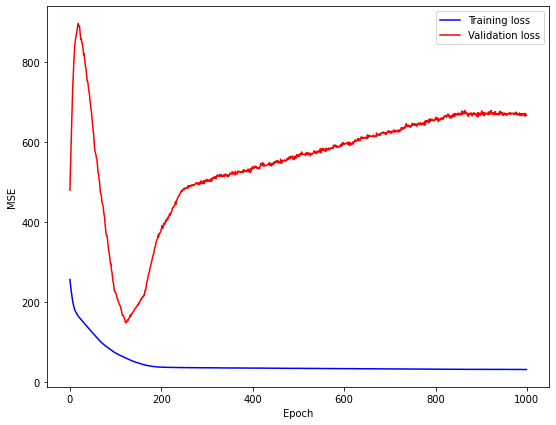

In [11]:
mse = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(epochs, mse, 'r', label='Training loss', color='blue')
plt.plot(epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()